# Fast Gradient Sign Method
# MNIST Example

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/home/jungj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Version info:

In [2]:
import sys
print("Python version: ", sys.version)
print("\nTensorFlow version: ", tf.__version__)

Python version:  3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]

TensorFlow version:  1.8.0-dev20180330


### Prepare MNIST data
MNIST can be imported using TensorFlow (Keras). It is automatically download and extracted.

In [3]:
img_size = 28
img_chan = 1
n_classes = 10

# Download, extract and import MNIST dataset
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Reshape and scale [0-255] -> [0.0-1.0]
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

# Convert class labels to one-hot encoding
to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Shuffle training samples and their labels
ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

# Separate some training samples as validation set
VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]

### Define classification model


In [4]:
# Define computational graph and methods for a simple CNN classifier with the ability to create adversarial examples
# Inspired by: https://github.com/gongzhitaao/tensorflow-adversarial
class SimpleCNN:
    def __init__(self, sess, img_size=28,img_chan=1):
        # Set the TF session
        self.sess = sess
        
        with tf.variable_scope('model'):
            # Define inputs and outputs of the model
            self.x = tf.placeholder(tf.float32, (None, img_size, img_size, img_chan), name='x')
            self.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
            self.training = tf.placeholder_with_default(False, (), name='mode') # to control dropout e.g.
            self.y_pred, logits = self._model(self.x, logits=True, training=self.training)
            
            # Define metric function 
            count = tf.equal(tf.argmax(self.y, axis=1), tf.argmax(self.y_pred, axis=1))
            self.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

            # Define loss and optimization procedure
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=logits), name='loss')
            optimizer = tf.train.AdamOptimizer()
            self.train_op = optimizer.minimize(self.loss)
            
        with tf.variable_scope('model', reuse=True):
            # Define computational graph to generate adversarial examples
            self.eps = tf.placeholder(tf.float32, (), name='eps')
            self.x_adv = self._fgsm(self.x, eps=self.eps)

    def _model(self, x, logits=False, training=False):
        # Define network architecture
        # CONV -> POOL -> CONV -> POOL -> DENSE -> DENSE
        with tf.variable_scope('conv0'):
            z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                                 padding='same', activation=tf.nn.relu)
            z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

        with tf.variable_scope('conv1'):
            z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3],
                                 padding='same', activation=tf.nn.relu)
            z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

        with tf.variable_scope('flatten'):
            shape = z.get_shape().as_list()
            z = tf.reshape(z, [-1, np.prod(shape[1:])])

        with tf.variable_scope('mlp'):
            z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
            z = tf.layers.dropout(z, rate=0.25, training=training)

        logits_ = tf.layers.dense(z, units=10, name='logits')
        y = tf.nn.softmax(logits_, name='ybar')

        if logits:
            return y, logits_
        return y
    
    # Define fast gradient sign method
    def _fgsm(self, x, eps=0.01):
        # get prediction and logits
        y, logits = self._model(x, logits=True)
        
        # get predicted lables as one-hot encoding
        indices = tf.argmax(y, axis=1)
        target = tf.one_hot(indices, depth=y.get_shape().as_list()[1])
        
        #compute the sign of the gradient of the loss w.r.t. the input
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=logits)
        x_adv = tf.stop_gradient(x + eps * tf.sign(tf.gradients(loss, x)))
        # clip to prevent over-/underflows
        x_adv = tf.clip_by_value(x_adv, clip_value_min=0, clip_value_max=1)

        return x_adv
    
    # Compute loss value and accuracy for given data
    def evaluate(self, X_val, y_val, batch_size=128):
        print("\nEvaluating ...")
        
        n_samples = X_val.shape[0]
        n_batches = int((n_samples+batch_size-1)/batch_size)
        loss, acc = 0, 0
        
        for batch in range(n_batches):
            start = batch*batch_size
            end = min(n_samples, start + batch_size)
            cnt = end-start
            batch_loss, batch_acc = sess.run([self.loss, self.acc],
                                             feed_dict={self.x: X_val[start:end],
                                                        self.y: y_val[start:end]})
            loss += batch_loss * cnt
            acc += batch_acc * cnt
        loss /= n_samples
        acc /= n_samples
        
        print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
        return loss, acc
    
    # Train the model on given input data, evaluate after each epoch
    def train(self, X_train, y_train, X_val, y_val, epochs=1, shuffle=True, batch_size=128):
        print("\nTraining ...")
        
        n_samples = X_train.shape[0]
        n_batches = int((n_samples+batch_size-1)/batch_size)
        
        for epoch in range(epochs):
            print("Epoch {0}/{1}".format(epoch+1, epochs))
            if shuffle:
                ind = np.arange(n_samples)
                np.random.shuffle(ind)
                X_train = X_train[ind]
                y_train = y_train[ind]
                
            for batch in range(n_batches):
                start = batch*batch_size
                end = min(n_samples, start + batch_size)
                self.sess.run(self.train_op, feed_dict={self.x: X_train[start:end],
                                                        self.y: y_train[start:end],
                                                        self.training: True})
            self.evaluate(X_valid, y_valid)
            
    # Predict labels for given data
    def predict(self, X_data, batch_size=128):
        print("\nPredicting ...")
        n_classes = 10
        n_samples = X_data.shape[0]
        n_batches = int((n_samples+batch_size-1) / batch_size)
        y_pred = np.empty((n_samples, n_classes))
        
        for batch in range(n_batches):
            start = batch*batch_size
            end = min(n_samples, start+batch_size)
            y_batch = sess.run(self.y_pred, feed_dict={self.x: X_data[start:end]})
            y_pred[start:end] = y_batch
        return y_pred
    
    # Generate adversarial examples from given data
    def generate_adversaries(self, X_data, eps=0.01, batch_size=128):
        n_sample = X_data.shape[0]
        n_batches = int((n_sample + batch_size - 1) / batch_size)
        X_adv = np.empty_like(X_data)

        for batch in range(n_batches):
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            adv = self.sess.run(self.x_adv, feed_dict={
                self.x: X_data[start:end],
                self.eps: eps})
            X_adv[start:end] = adv

        return X_adv

### Create TF session and initialize previously defined graph

In [5]:
tf.reset_default_graph()
# if sess is not None: sess.close()
sess = tf.InteractiveSession()
simpleCNN = SimpleCNN(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [6]:
simpleCNN.train(X_train, y_train, X_valid, y_valid, epochs=3)


Training ...
Epoch 1/3

Evaluating ...
 loss: 0.0698 acc: 0.9782
Epoch 2/3

Evaluating ...
 loss: 0.0458 acc: 0.9862
Epoch 3/3

Evaluating ...
 loss: 0.0440 acc: 0.9867


In [7]:
simpleCNN.evaluate(X_test,y_test)


Evaluating ...
 loss: 0.0305 acc: 0.9901


(0.03045549012282863, 0.9901)

In [8]:
X_adv = simpleCNN.generate_adversaries(X_test, eps=0.15)
simpleCNN.evaluate(X_adv,y_test)


Evaluating ...
 loss: 0.9309 acc: 0.6926


(0.9308546092033386, 0.6926)


Predicting ...

Predicting ...
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 6
Target 7
Target 8
Target 9

Plotting results


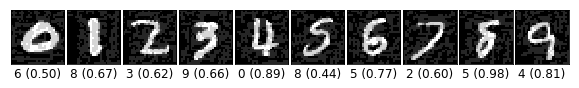

In [11]:
y1 = simpleCNN.predict(X_test)
y2 = simpleCNN.predict(X_adv)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

# print(set(z0))
# print(set(z1))
# print(set(z2))

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))
for i in range(10):
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0 == i, z1 == i, z2 != i], axis=0))
    cur = np.random.choice(ind)
    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]

print('\nPlotting results')

fig = plt.figure(figsize=(10, 1.2))
gs = gridspec.GridSpec(1, 10, wspace=0.05, hspace=0.05)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)
    
plt.savefig("adv_example.png")